In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn

In [103]:
from sklearn.model_selection import train_test_split

In [104]:
#Import dataset
data=pd.read_csv('/Users/dl/Downloads/datasets_heart_failure_clinical_records_dataset.csv')

### Task 2: Starting Questions

In [105]:
#i. Total number of records
total_records=data.shape[0]
print("Number of records: "+str(total_records))

Number of records: 299


In [106]:
#ii. Total number of columns, quantitative and qualitative
total_columns=data.shape[1]
total_columns

13

In [107]:
data.nunique()

age                          47
anaemia                       2
creatinine_phosphokinase    208
diabetes                      2
ejection_fraction            17
high_blood_pressure           2
platelets                   176
serum_creatinine             40
serum_sodium                 27
sex                           2
smoking                       2
time                        148
DEATH_EVENT                   2
dtype: int64

Assuming that qualitative variables should have less than 10 unique values, we now see that there are 13 columns in total, 6 binary categorical variables and 7 quantitative variables. Note the qualitative columns have numerical datatypes, which is why we could not use _get_numerical_data to find the answer.

In [108]:
#iii. Missing data / Quality of data
data.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

From the results, we can see there are no missing in any columns of the dataset. We should check the existence of duplicates as well.

In [109]:
data.duplicated().sum()

0

We can see there are no duplicates either. Hence we could conclude the data has good quality.

In [110]:
#iv. Death counts
#We know death_count is a categorical variable with 1 as a death event, and 0 otherwise.
#The [1] means we want the second entry of the value_counts vector.
death_count=data["DEATH_EVENT"].value_counts()[1]
print("There are %s death records." %(death_count))

There are 96 death records.


### Task 3: EDA

The summary consists of a few sections, each starting with a # sentence, to describe a few significant points.

In [111]:
#Investigating relationship between high blood pressure and death in heart failure
data.groupby('high_blood_pressure')["DEATH_EVENT"].value_counts()

high_blood_pressure  DEATH_EVENT
0                    0              137
                     1               57
1                    0               66
                     1               39
Name: DEATH_EVENT, dtype: int64

We can see people having high blood pressure has a lethality of 39/(39+66)=37% in heart failure, while people not having high blood pressure has a lethality of 57/(57+137)=29% in heart failure. So, people having high blood pressure are **~28%**(=(37-28)/28) **riskier to die during a heart failure**.

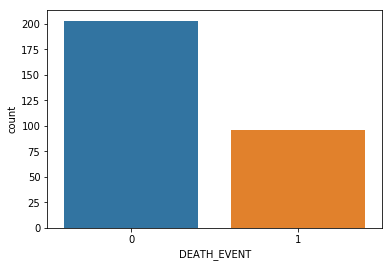

In [112]:
#Plotting death count
sns.countplot(x="DEATH_EVENT", data=data);

From the graph, we found that death cases are much less than non-death cases, which means there would be a class imbalance.

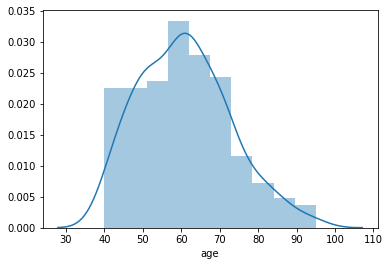

In [113]:
#Distribution of age
sns.distplot(data["age"], bins=10, vertical=False);

The distribution of age in the dataset is approximately bell-shaped, which means it is not heavily skewed towards either of the age range.

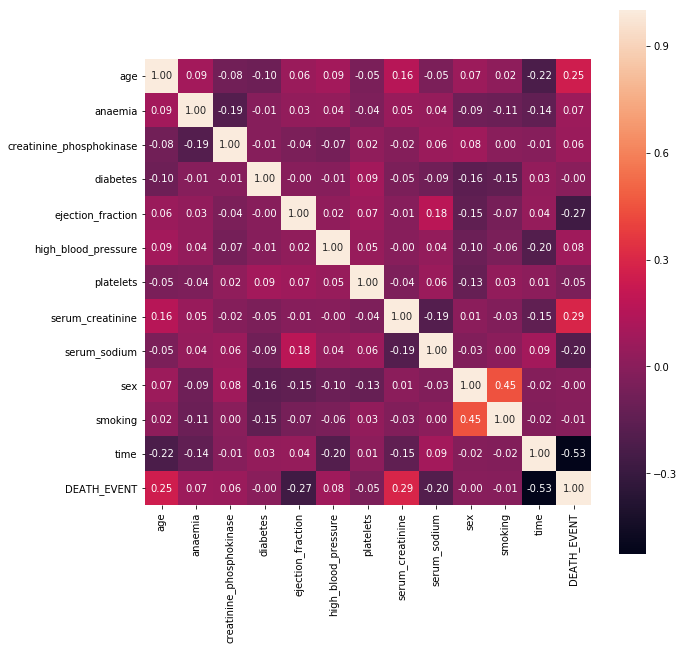

In [114]:
#Multivariate correlation
fig, ax = plt.subplots(figsize=(10,10)) #specify dimensions
#The corr() function returns the correlation matrix of the dataset
sns.heatmap(data.corr(), square=True, annot=True, fmt='.2f', linecolor='white', ax=ax)

We could see all potential predictor variables have low correlation with one another except smoking and sex, and age, ejection_fraction (% of blood leaving heart in each contraction), serum_creatinine (level of serum creatinine in the blood (mg/dL) ) and time (follow-up period (days)) has a high correlation with our target, DEATH_EVENT.

*(Note all explanations of variables come from UCI)*

### Task 4: Modelling

In [162]:
#i. Split into train and test
data_dropdeath=data.drop(data.columns[-1],axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_dropdeath, data["DEATH_EVENT"], test_size=0.2, random_state=771324)

In [163]:
#ii. Model Selection

Since this is a binary classification problem and the dataset is relatively regular and small, we could try using Naive Bayes first. Naive Bayes is simple, has no hyperparameters, and could act as a benchmark to evaluate other models against.

In [164]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold #stratified since there exists class imbalance
from sklearn.ensemble import RandomForestClassifier

In [184]:
X_train = preprocessing.MinMaxScaler().fit_transform(X_train) #scaling before ML
nbmodel=GaussianNB()
nbmodel.fit(X=X_train,y=y_train)
#in-sample accuracy
print('In-sample accuracy:', nbmodel.score(X_train,y_train)) #.score calls Accuracy

In-sample accuracy: 0.7740585774058577


Next, we could try out Random Forests and tune some of the dominant hyperparameters. Random Forest is better than a decision tree since it lowers variance by ensemble while maintaining low bias. In the case of no or few outliers (which this dataset indeed is), Random Forest is even more suitable.

In [166]:
from sklearn.ensemble import RandomForestClassifier

In [167]:
rf=RandomForestClassifier()
rs_kfold=RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=771324)
params_rf={'n_estimators':[10,20,50,100],
           'max_features':[2,3,5,7],
           'min_samples_leaf':[2,5,10,20],
           'bootstrap':[True,False],
           'min_samples_split':[2,5,10,20]}
rscv_rf = RandomizedSearchCV(estimator=rf, #Randomized Search could lower computing power needed
                      param_distributions=params_rf,
                      n_iter=200,
                      cv=rs_kfold,
                      verbose=1,
                      random_state=1324,
                      scoring='accuracy', 
                      return_train_score=True,
                      n_jobs=-1) #njobs=-1 tells the computer to use all cores

In [168]:
rscv_rf.fit(X_train,y_train)

Fitting 15 folds for each of 200 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.2min finished


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=771324),
                   estimator=RandomForestClassifier(), n_iter=200, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': [2, 3, 5, 7],
                                        'min_samples_leaf': [2, 5, 10, 20],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [10, 20, 50, 100]},
                   random_state=1324, return_train_score=True,
                   scoring='accuracy', verbose=1)

In [169]:
rscv_rf.best_params_

{'bootstrap': True,
 'max_features': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 10}

Note using our parameter grid, RandomizedSearchCV probably isn't the best result compared to GridSearchCV. The reason to use RandomizedSearchCV here is to reduce the computational power here. Picking a random distribution of all possible combinations here actually would not work so bad: there is almost no outliers in the dataset, and so the decision hypersurface should be sufficiently smooth.

In [170]:
rscv_rf.best_score_

0.8521572104018913

We have obtained a score of 85.2%, which is significantly higher than that of Naive Bayes. This is expected, since we did tweak the hyperparameters this time.

In [173]:
#iii. Prediction
from sklearn.metrics import roc_auc_score #we use area under curve instead of accuracy score because of class imbalance
rf_final=rscv_rf.best_estimator_
y_predict=rf_final.predict(X_test)
print('Test ROC_AUC score:', roc_auc_score(y_test,y_predict))

Test ROC_AUC score: 0.43160054719562246


In [172]:
y_predict

array([0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [180]:
#Feature importance ranking
print("Features sorted by their score:",sorted(zip(map(lambda x: round(x, 4), rf_final.feature_importances_), data.columns), 
             reverse=True))

Features sorted by their score: [(0.504, 'time'), (0.1706, 'serum_creatinine'), (0.1473, 'ejection_fraction'), (0.0496, 'age'), (0.0461, 'creatinine_phosphokinase'), (0.0247, 'platelets'), (0.0243, 'serum_sodium'), (0.0145, 'anaemia'), (0.0077, 'sex'), (0.0054, 'diabetes'), (0.0031, 'high_blood_pressure'), (0.0028, 'smoking')]


### Task 5: Final summary

Write a super-brief (under 200 words) summary of your process, the dataset and your model (including what features were most important).


This is an investigation on lethalities of heart failure. First, we inspected the data and concluded the data is in good quality. We then explored the data to grasp basic information: we know there are 13 features (6 qualitative and 7 quantitative), ~300 rows). We also noticed the data is in class imbalance, as number of non-deaths are 2 times more than deaths. Next, we explored further in hopes to find hypotheses on dominant predictors of death, with visualisations in between, ending with a heatmap to show correlation between all variables. Then, to do the modelling, we first split the data in 80-20, and used Naive Bayes as a comparison towards the Random Forests we will focus on. We focused on grid-searching several traditionally dominant hyperparameters (eg. n_estimators), and randomized the search to achieve a lower computational power while not harming too much on the performance. At last, while evaluating the prediction, we used ROC_AUC score since the data is intrinsically in imbalance. Note that the feature importance ranking (as part of output of final model) claims time, serum_creatinine and ejection_fraction as 3 most important factors, which coincides with the final row of the heatmap.